# CS5489 - Machine Learning
# Lecture 10a - Deep Learning
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
- Going deeper
  - ReLU and Batchnorm
- Optimization methods
- Deep architectures and Image classification
- Transfer learning

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from scipy import signal

rbow = plt.get_cmap('rainbow')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras import backend as K
import logging
logging.basicConfig()
import struct
print(keras.__version__, tf.__version__)
# use keras backend (K) to force channels-last ordering
K.set_image_data_format('channels_last')

2.4.0 2.4.1


In [3]:
def plot_history(history, showacc=True): 
    fig, ax1 = plt.subplots()
    
    ax1.plot(history.history['loss'], 'r', label="training loss ({:.6f})".format(history.history['loss'][-1]))
    ax1.plot(history.history['val_loss'], 'r--', label="validation loss ({:.6f})".format(history.history['val_loss'][-1]))
    ax1.grid(True)
    ax1.set_xlabel('epoch')
    ax1.legend(loc="best", fontsize=9)    
    ax1.set_ylabel('loss', color='r')
    ax1.tick_params('y', colors='r')

    if showacc and ('accuracy' in history.history):
        ax2 = ax1.twinx()

        ax2.plot(history.history['accuracy'], 'b', label="training acc ({:.4f})".format(history.history['accuracy'][-1]))
        ax2.plot(history.history['val_accuracy'], 'b--', label="validation acc ({:.4f})".format(history.history['val_accuracy'][-1]))

        ax2.legend(loc="best", fontsize=9)
        ax2.set_ylabel('acc', color='b')        
        ax2.tick_params('y', colors='b')

In [4]:
def show_imgs(W_list, nc=10, highlight_green=None, highlight_red=None, titles=None):
    nfilter = len(W_list)
    nr = (nfilter - 1) // nc + 1
    for i in range(nr):
        for j in range(nc):
            idx = i * nc + j
            if idx == nfilter:
                break
            plt.subplot(nr, nc, idx + 1)
            cur_W = W_list[idx]
            plt.imshow(cur_W,cmap='gray', interpolation='nearest')  
            if titles is not None:
                plt.title(titles % idx)
            
            if ((highlight_green is not None) and highlight_green[idx]) or \
               ((highlight_red is not None) and highlight_red[idx]): 
                ax = plt.gca()
                if highlight_green[idx]:
                    mycol = '#00FF00'
                else:
                    mycol = 'r'
                for S in ['bottom', 'top', 'right', 'left']:
                    ax.spines[S].set_color(mycol)
                    ax.spines[S].set_lw(2.0)
                ax.xaxis.set_ticks_position('none')               
                ax.yaxis.set_ticks_position('none')
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                plt.gca().set_axis_off()


In [5]:
def read_32int(f):
    return struct.unpack('>I', f.read(4))[0]
def read_img(img_path):
    with open(img_path, 'rb') as f:
        magic_num = read_32int(f)
        num_image = read_32int(f)
        n_row = read_32int(f)
        n_col = read_32int(f)
        #print 'num_image = {}; n_row = {}; n_col = {}'.format(num_image, n_row, n_col)
        res = []
        npixel = n_row * n_col
        res_arr = fromfile(f, dtype='B')
        res_arr = res_arr.reshape((num_image, n_row, n_col), order='C')
        #print 'image data shape = {}'.format(res_arr.shape)
        return num_image, n_row, n_col, res_arr    
def read_label(label_path):
    with open(label_path, 'rb') as f:
        magic_num = read_32int(f)
        num_label = read_32int(f)
        #print 'num_label = {}'.format(num_label)
        res_arr = fromfile(f, dtype='B')
        #print res_arr.shape
        #res_arr = res_arr.reshape((num_label, 1))
        res_arr = res_arr.ravel()
        #print 'label data shape = {}'.format(res_arr.shape)
        return num_label, res_arr

In [6]:
n_train, nrow, ncol, trainimg = read_img('data/train-images.idx3-ubyte')
_, trainY = read_label('data/train-labels.idx1-ubyte')
n_test, _, _, testimg = read_img('data/t10k-images.idx3-ubyte')
_, testY = read_label('data/t10k-labels.idx1-ubyte')

# for demonstration we only use 10% of the training data
sample_index = range(0, trainimg.shape[0], 10)
trainimg  = trainimg[sample_index]
trainY    = trainY[sample_index]
print(trainimg.shape)
print(trainY.shape)
print(testimg.shape)
print(testY.shape)

# convert class labels to binary indicators
trainYb = keras.utils.to_categorical(trainY)

(6000, 28, 28)
(6000,)
(10000, 28, 28)
(10000,)


In [7]:
# scale to 0-1
trainI = (trainimg.reshape((6000,28,28,1)) / 255.0)
testI  = (testimg.reshape((10000,28,28,1)) / 255.0)
print(trainI.shape)
print(testI.shape)

(6000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
# generate fixed validation set of 10% of the training set
vtrainI, validI, vtrainYb, validYb = \
  model_selection.train_test_split(trainI, trainYb, 
  train_size=0.9, test_size=0.1, random_state=4487)

validsetI = (validI, validYb)

# Problems with Going Deeper

- **Vanishing Gradient Problem 1**
  - successive multiplications of small gradients gives smaller gradients, and converges to 0
  - the gradients backpropagated to the first few layers has small signal.

- Example: for  4-layers, 

 <center><img src="imgs/deepeg.png" width=600></center>
 
$$\frac{dL}{d \mathbf{a}_j}= \frac{d\mathbf{g}_1^T}{d\mathbf{a}_j} \frac{d\mathbf{z_1}^T}{d\mathbf{g}_1}\frac{d\mathbf{g}_2^T}{d\mathbf{z_1}}\frac{d\mathbf{z_2}^T}{d\mathbf{g}_2}\frac{d\mathbf{g}_3^T}{d\mathbf{z_2}}\frac{d\mathbf{z_3}^T}{d\mathbf{g}_3}\frac{d\mathbf{g}_4^T}{d\mathbf{z_3}}\frac{d\mathbf{f}^T}{d\mathbf{g}_4} \frac{dL}{d\mathbf{f}}
  $$

- **Vanishing Gradient Problem 2**
  - using backprop, the gradient at a node is the summation over $O(H^D)$ paths
    - $D$ is the number of layers to the output layer.
    - $H$ is the number of  nodes in the layer.    
  - the original loss signal gets "washed out".

<center><img src="imgs/gpaths.png" width=400></center>

- **Dataset Size**
  - a "small" network with just 40 inputs, 30 hidden nodes, and 1 output has ~1200 parameters.
  - if we don't have enough samples:
    - large variance in the parameter estimator  (what you  get may be far from the truth)
    - deeper networks are more complex, which are easier to overfit the training data.

- *How many samples do we need?*    
   - Theorem (Bartlett, Maiorov, Meir, 1998)
> Suppose $\cal N$ is a feed-forward network with $W$ weights, $L$ layers, and all non-output gates having a fixed piecewise-polynomial activation function with a fixed number of pieces (e.g., ReLU). Then $VCdim({\cal N}) = O(WL \log W + WL^2)$.





  - If the sample size is large compared to the VC dimension, then the learned classifier will generalize well.
    - for the same number of parameters, the deeper network requires more data ($WL^2$).
    - increasing the number of weights, requires a super-linear increase in sample size ($W\log W$).
    

# ReLU activation function
- Rectified Linear Unit: $\mathrm{ReLU}(z) = \max(0,z)$
  - easier to train with: gradient is either 0 or 1.
  - faster: don't need to calculate exponential
  - sparse representation: most nodes will output zero.

In [9]:
x=linspace(-5,5,200)
fs = {'ReLU':    lambda x: maximum(0,x),
     }

actfig = plt.figure(figsize=(5,3))
for name,f in fs.items():
    plt.plot(x, f(x), label=name)
plt.legend(loc="lower right")
plt.axis([-5,5,-0.5,5])
plt.grid(True)
plt.close()


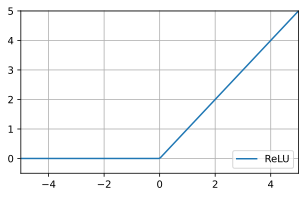

In [10]:
actfig

# Advantage of Sparsity
- if a hidden node $h=0$, then $\frac{dL}{dh}=0$.
  - This blocks some paths when computing the gradients.
  - Gradient signal  is less washed out.
  - Reduces the vanishing gradient problem.
  
<center><img src="imgs/gpaths2.png" width=400></center>

# Better Network Parameterization
- There are equivalent parameterizations of the network by scaling up/down the weights in  successive layers.
  - $f(\mathbf{x}) = \mathbf{A}^T r( \mathbf{B}^T \mathbf{x}) = \frac{1}{\epsilon}\mathbf{A}^T r( \epsilon\mathbf{B}^T \mathbf{x})$
    - $\epsilon>0$ and $r(\cdot)$ is the ReLU activation.
- **Problem:**
  - "internal covariate shift" - change in the distribution of activations during training, due to changes in the parameters.
  
<center><img src="imgs/drift.png" width=200></center>

# Why is it bad?
- suppose, we have a linear network:
 -  $y= x w_1 w_2 w_3 w_4$
 - gradient of each layer is $(g_1, \cdots , g_4)$
- update the parameters with GD:
  - $y = x (w_1-\eta g_1)(w_2-\eta g_2)(w_3-\eta g_3)(w_4-\eta g_4)$
     - there are many  higher-order terms, e.g., $w_1w_2\eta^2g_3g_4$
  - although $w_i$ are updated independently, they strongly affect each other.
  - hence, if the distribution  of activations changes in 1 layer, then all layers are affected, and we need to adjust other layers.

# Solution: Batch Normalization
- For each node in  each layer, normalize the outputs to zero mean and unit variance, *over each mini-batch*.
  - this is analogous to the idea of normalizing the input feature vector to (0,1) Gaussian with  standard ML models!

- Place batchnorm layer after linear transformation.
<center><img src="imgs/batchnorm.png" width=400></center>

  - Let $\{y_i\}_{i=1}^N$ be the output of the linear transform in one minibatch. 
  - For each node  (dimension) in the layer:
    - normalize: $\hat{y}_i = \frac{y_i - \mu}{\sqrt{\sigma^2+\epsilon}}$
      - $\mu,\sigma^2$ are the mean and variance of $\{y_i\}$ in the mini-batch.
      - $\epsilon$ is a small constant for numerical stability.
    - scale-shift: $z_i = \gamma \hat{y}_i+\beta$
      - $\gamma,\beta$ are learnable parameters
      - puts the output in the proper regime of the non-linear activation.
    - The final distribution has mean $\beta$ and variance $\gamma^2$.

- Notes: 
  - batchnorm is applied to each node independently.
  - should put the batchnorm layer after the linear transformation layer.
  - the bias of the linear layer is not necessary since it is removed by batchnorm
- Training:
  - gradients can be computed through the batchnorm layer as usual.
- Training effects:
  - training is accelerated; can use higher learning rates
  - more stable gradients during training
    - increasing the scale of the activations decreases the gradient
    - self-correcting stabilization.
  - better generalization
    - no need for dropout or L2 regularization.

# Example: MNIST
- for each Conv2D/Dense layer:
  - change activation to linear (default); remove bias term
  - append batch-norm and ReLU activation


In [11]:
def build_nn():
    K.clear_session()  # cleanup
    # initialize random seed
    random.seed(4487); tf.random.set_seed(4487)

    # build the network
    nn = Sequential()
    nn.add(Conv2D(10, (5,5), strides=(2,2), input_shape=(28,28,1),
                  padding='same', use_bias=False))
    nn.add(BatchNormalization(axis=3)) # apply batchnorm on channels
    nn.add(Activation("relu"))
    nn.add(Conv2D(40, (5,5), strides=(2,2), padding='same', use_bias=False))
    nn.add(BatchNormalization(axis=3))
    nn.add(Activation("relu"))
    nn.add(Conv2D(80, (5,5), strides=(1,1), padding='same', use_bias=False))
    nn.add(BatchNormalization(axis=3))
    nn.add(Activation("relu"))
    nn.add(Flatten())
    nn.add(Dense(units=50, use_bias=False))
    nn.add(BatchNormalization())
    nn.add(Activation("relu"))
    nn.add(Dense(units=10, activation='softmax'))

    return nn

In [12]:
nn = build_nn()

# setup early stopping callback function
earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto'
)
callbacks_list = [earlystop]
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00025: early stopping


- Test results
  - compared with L2-regularization (0.966), dropout (0.968), ensemble (0.970)

test accuracy: 0.9804


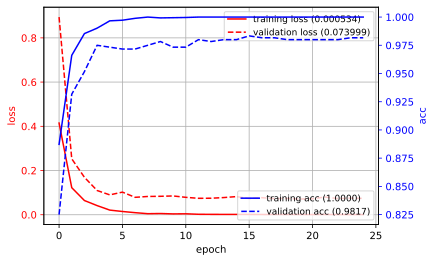

In [13]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Outline
- Going deeper
  - ReLU and Batchnorm
- **Optimization methods**
- Deep architectures and Image classification
- Transfer learning

# Optimization with SGD
- Ideally, we would l ike to use all the samples to compute the gradient, but this is too time consuming.
- Use a *minibatch* (a few samples) at a time to estimate the gradient.
  - creates an unbiased estimator of the gradient.
  - the variance (expected squared error) depends on the number of samples.
    - i.e., the estimated gradient is *noisy*.

# Learning rates
- **Problem:** For gradient descent, at the minimum we should  have $\frac{dL}{d\mathbf{w}}=0$.
- *What about for SGD?*
  - at the minimum $\frac{dL}{d\mathbf{w}} \neq 0$ because of noise in the gradient.
    - SGD still moves around.

- Solution: reduce the learning rate during the epochs.
  - Examples: for iteration/epoch $k$,
    - **linear change:** $\eta_k = (1-\alpha)\eta_0 + \alpha \eta_T$, where $\alpha = k/T$, and $\eta_0,\eta_T$ given.
    - **decay:** $\eta_k = \frac{1}{1+\delta k} \eta_{0}$, where $0<\delta<1$.
  - we want a small learning rate when we are close to the minimum.
    - needs to be set empirically by examining the learning curves.



# Example: Keras decay
- use the built-in `decay` parameter.
  - applied after each batch.

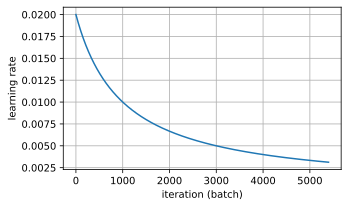

In [14]:
plt.figure(figsize=(5,3))
its = arange(0,50*5400/50)  # 50 epochs, 5400/50 iterations per epoch
lr = 0.02*(1./(1+its*1e-3))
plt.plot(its, lr)
plt.grid(); plt.xlabel('iteration (batch)'); plt.ylabel('learning rate');

In [15]:
nn = build_nn()
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, 
                                decay=1e-5,  # decay LR each iteration (batch) 
                                momentum=0.9, nesterov=True), 
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=50, batch_size=50, 
                 validation_data=validsetI, verbose=False)

test accuracy: 0.9805


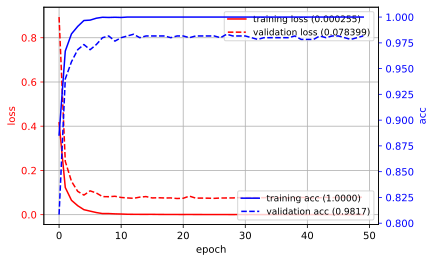

In [16]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Adaptive schedule
- reduce the learning rate when the validation loss no longer improves
  - similar to early stopping criteria
- implemented as a callback function

In [17]:
# reduce LR by a factor of 0.1, if no change in 5 epochs
lrschedule = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.1, patience=5, verbose=1)
callbacks_list = [lrschedule]

In [18]:
nn = build_nn()
       
# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=50, batch_size=50, 
                 callbacks=callbacks_list,
                 validation_data=validsetI, verbose=False)


Epoch 00025: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0001999999862164259.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1.9999998039565982e-05.

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.99999976757681e-06.

Epoch 00045: ReduceLROnPlateau reducing learning rate to 1.99999976757681e-07.

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.9999997391551008e-08.


test accuracy: 0.9803


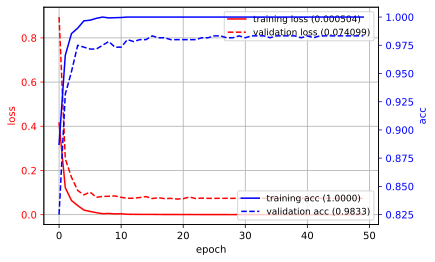

In [19]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Fixed schedule
- specify our own schedule using callback `LearningRateScheduler`
- pass a schedule function 
 - inputs are the epoch and current learning rate.
 - outputs the learning rate for this epoch.

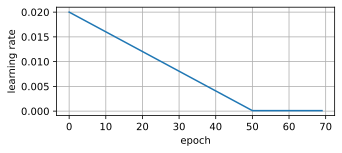

In [28]:
def sc(epoch, curlr):
    alpha = minimum(epoch/50, 1.)
    return 0.02*(1-alpha)+0.0001*alpha
epoch = arange(0,70)
plt.figure(figsize=(5,2))
plt.plot(epoch, sc(epoch,None))
plt.grid(); plt.xlabel('epoch'); plt.ylabel('learning rate');

In [21]:
nn = build_nn()

# learning rate schedule
lrschedule = keras.callbacks.LearningRateScheduler(sc, verbose=0)
callbacks_list = [lrschedule]

# compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.SGD(lr=0.02, momentum=0.9, nesterov=True), 
          metrics=['accuracy'])

history = nn.fit(vtrainI, vtrainYb, epochs=50, batch_size=50, 
                 callbacks=callbacks_list,
                 validation_data=validsetI, verbose=False)

test accuracy: 0.9799


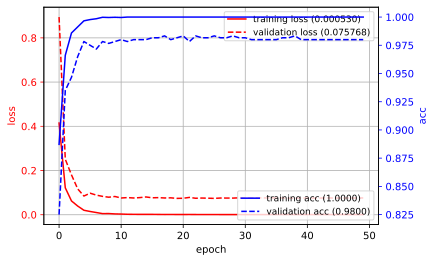

In [22]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Momentum
- **Problem**: The estimated gradient is noisy, can jump around.
- **Solution**: keep a running average of the gradients across mini-batches.
  - velocity: $\mathbf{v}^{(t)} = \alpha \mathbf{v}^{(t-1)} - \eta 
  \left.\frac{dL}{d\mathbf{w}}\right\vert_{\mathbf{w}^{(t-1)}}$
    - accumulate the gradients
    - $\alpha$ is the momentum hyperparameter; how much it exponentially decays.
  - parameter update: $\mathbf{w}^{(t)} \leftarrow \mathbf{w}^{(t-1)} + \mathbf{v}^{(t)}$

- Example:
  - red path is using momentum
  - black arrows show the gradient directions at each step
  - without momentum, the path would oscillate wildly.
<center><img src="imgs/momentum.png" width=300></center>

# Nesterov Momentum
- Compute the gradient *after* the current velocity is applied.
  - interim update: $\tilde{\mathbf{w}} = \mathbf{w}^{(t-1)}+\alpha\mathbf{v}^{(t-1)}$
  - velocity: $\mathbf{v}^{(t)} = \alpha \mathbf{v}^{(t-1)} - \eta 
  \left.\frac{dL}{d\mathbf{w}}\right\vert_{\tilde{\mathbf{w}}}$
  - parameter update: $\mathbf{w}^{(t)} \leftarrow \mathbf{w}^{(t-1)} + \mathbf{v}^{(t)}$
- Adds a *correction factor* to improve convergence (for convex batch case)


# Why does SGD work?
- The loss function  has many local minima
- SGD adds "noise" to the true gradient.
  - the noise allows escaping/avoiding/jumping over small local minima.
 

 
- Example:
  - red arrow = true gradient
  - green arrow = added noise
  - black arrow = computed gradient
<center><img src="imgs/sgdeg.png" width=400></center>

# SGD smoothes the loss function
- the added gradient noise is equivalent to convolving the loss function with the noise density.
- higher learning rate -> larger noise -> smoother loss
   <center><img src="imgs/sgdsmooth1.png" width=800></center>


- higher learning rate -> larger noise -> smoother loss
   <center><img src="imgs/sgdsmooth1.png" width=800></center>
- smoother loss removes the local minimum, making it easier to get near the global minimum.
  - but not exactly on it.
   <center><img src="imgs/sgdsmooth2.png" width=800></center>

   - need to reduce the learning rate in stages to converge to the global  optimum.
   <center><img src="imgs/sgdsmooth3.png" width=800></center>




<center><img src="imgs/sgdsmooth.png" width=1000></center>

# Optimization with Adaptive Learning Rates
- Introduce a separate learning rate for each parameter, and automatically adapt the learning rates during optimization.
- **AdaGrad** (`keras.optimizers.Adagrad`)
  - adapt individual learning rates by dividing by the square-root of the gradient energy accumulated over the iterations.
    - $\mathbf{g} = \frac{dL}{d\mathbf{w}}$
    - $\mathbf{r}^{(t)} = \mathbf{r}^{(t-1)} + \mathbf{g}^2$
    - $\mathbf{w}^{(t)}  = \mathbf{w}^{(t-1)} -\frac{\eta}{\delta+\sqrt{\mathbf{r}}} \mathbf{g}$
  - (operations are element-wise)
- **RMSProp** (`keras.optimizers.RMSprop`)
  - use exponential decay on the accumulated energy:
    - $\mathbf{r}^{(t)} = \rho \mathbf{r}^{(t-1)} + (1-\rho)\mathbf{g}^2$


- **Adam** (`keras.optimizers.Adam`)
  - use momentum with exponential weighting to estimate the gradient and gradient energy.
    - $\mathbf{s}^{(t)}  = \rho_1\mathbf{s}^{(t-1)} + (1-\rho_1) \mathbf{g}$
    - $\mathbf{r}^{(t)}  = \rho_2\mathbf{r}^{(t-1)} + (1-\rho_2) \mathbf{g}^2$
  - adds a bias correction for these two estimates.
    - $\mathbf{\hat{s}}^{(t)} = \frac{1}{1-\rho_1^t}\mathbf{s}^{(t)}$
    - $\mathbf{\hat{r}}^{(t)} = \frac{1}{1-\rho_2^t}\mathbf{r}^{(t)}$
  - update:
    - $\mathbf{w}^{(t)} = \mathbf{w}^{(t-1)} -  \frac{\eta}{\delta+\sqrt{\mathbf{\hat{r}}^{(t)}}}\mathbf{\hat{s}}^{(t)}$


# Example
- change the optimizer when compiling the network.

In [23]:
nn = build_nn()

# setup early stopping callback function
earlystop = keras.callbacks.EarlyStopping(
    monitor='val_loss',     # look at the validation loss
    min_delta=0.0001,       # threshold to consider as no change
    patience=5,             # stop if 5 epochs with no change
    verbose=1, mode='auto'
)
callbacks_list = [earlystop]

In [24]:
 # compile and fit the network
nn.compile(loss=keras.losses.categorical_crossentropy,
           optimizer=keras.optimizers.Adam(lr=0.01),   # can set the initial learning rate too
          metrics=['accuracy'])
history = nn.fit(vtrainI, vtrainYb, epochs=100, batch_size=50, 
                 callbacks=callbacks_list, 
                 validation_data=validsetI, verbose=False)

Epoch 00012: early stopping


test accuracy: 0.9608


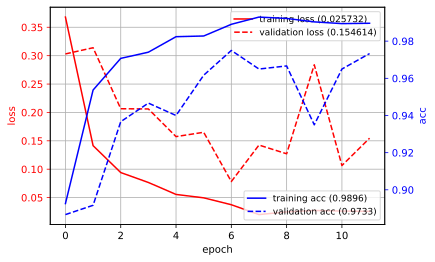

In [25]:
plot_history(history)

predY = argmax(nn.predict(testI, verbose=False), axis=-1)
acc = metrics.accuracy_score(testY, predY)
print("test accuracy:", acc)

# Which optimizer is best?
- there's no best optimizer...
- based on the problem and own familiarity with tuning the hyperparmeters.